<a href="https://colab.research.google.com/github/MrBCPT/Project2-Part1Core/blob/main/Satish_Byrow_Project_2_Part_4_(Core).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Student: Satish Byrow

#**1. Goal**
- Predict which features would most likely result in a stroke

##Dictionary
1) id: unique identifier<br>
2) gender: "Male", "Female" or "Other"<br>
3) age: age of the patient<br>
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension<br>
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease<br>
6) ever_married: "No" or "Yes"<br>
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"<br>
8) Residence_type: "Rural" or "Urban"<br>
9) avg_glucose_level: average glucose level in blood<br>
10) bmi: body mass index<br>
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*<br>
12) stroke: 1 if the patient had a stroke or 0 if not<br><br>
*Note: "Unknown" in smoking_status means that the information is unavailable for this patient<br>

#**2. Import and Loading**


## Load Libraries

In [74]:
#Load Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#import some necessary tools
from sklearn import set_config, preprocessing
set_config(transform_output='pandas')

from seaborn import heatmap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

#import accuracy, precision, recall, classification report, and confusion matrix scoring functions
from sklearn.metrics import (roc_auc_score, ConfusionMatrixDisplay,
                             PrecisionRecallDisplay, RocCurveDisplay,
                             f1_score, accuracy_score, precision_score,
                             recall_score, classification_report, confusion_matrix)

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer

## Define Functions

In [75]:
def eval_classification(model, X_train, X_test, y_train, y_test):
  print('Train Report:', classification_report(y_train, model.predict(X_train)))
  print('Test Report:', classification_report(y_test, model.predict(X_test)))

  cm = confusion_matrix(y_test, model.predict(X_test))

  plt.figure(figsize=(15, 15))
  heatmap(cm, annot=True)
  plt.xlabel('Predicted', fontsize=40)
  plt.ylabel('True', fontsize=40)
  plt.show()

In [76]:
def evaluate_model(model_pipe, X_train, y_train, X_test, y_test, labels):
  """Creates a classification report, including calculating and printing
   ROC AUC values. Generates ConfusionMatrix and RocCurve Display
    Source:{previous exercises and code alongs}
  """
  # Get predictions
  y_pred_train = model_pipe.predict(X_train)
  y_pred_test = model_pipe.predict(X_test)

  print('Train Report')
  print(classification_report(y_train, y_pred_train, target_names=labels))

  print('Test Report')
  print(classification_report(y_test, y_pred_test, target_names=labels))

  # roc_auc
  y_pred_proba_train = model_pipe.predict_proba(X_train)
  y_pred_proba_test = model_pipe.predict_proba(X_test)
  train_roc_auc = roc_auc_score(y_train, y_pred_proba_train[:,1])
  test_roc_auc = roc_auc_score(y_test, y_pred_proba_test[:,1])

  print(f'Training ROC AUC: {train_roc_auc:.2f}')
  print(f'Test ROC AUC: {test_roc_auc:.2f}')
  print()

  # Make figure for training and test conf matrix
  fig, axes = plt.subplots(ncols=2, figsize=(8,4))

  ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train, normalize='true',
                                          cmap='Greens', ax=axes[0], display_labels=labels)
  axes[0].set_title("Training Data")
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, normalize='true',
                                          cmap='Reds', ax=axes[1], display_labels=labels)
  axes[1].set_title("Test Data")

  fig.suptitle("Confusion Matrices")
  fig.tight_layout()
  plt.show()



  # Make figure for training and test conf matrix
  fig, axes = plt.subplots(ncols=2, figsize=(8,4))

  # Visualize the ROC curve
  RocCurveDisplay.from_estimator(model_pipe, X_train, y_train, ax=axes[0])
  axes[0].plot([0, 1], [0, 1], ls = '--', label = 'Baseline (AUC = 0.5)')
  axes[0].legend();
  axes[0].set_title("Training Data")

  RocCurveDisplay.from_estimator(model_pipe, X_test, y_test, ax=axes[1])
  axes[1].plot([0, 1], [0, 1], ls = '--', label = 'Baseline (AUC = 0.5)')
  axes[1].legend();
  axes[1].set_title("Test Data")

  fig.suptitle('ROC Curves')
  fig.tight_layout()
  plt.show()

## Load Data

In [77]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Data Source
 - https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

In [78]:
## Loading data from published google sheet
fpath ="/content/drive/MyDrive/CodingDojo/02-MachineLearning/Week05/Data/healthcare-dataset-stroke-data.csv"
df_main = pd.read_csv(fpath)

In [79]:
#Make a copy so we dont break the original data set and avoid any manipulations
df = df_main.copy()

#**3. Explore Data Set**

In [80]:
#Check then data
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


###Brief Description of Data
- The data is a view of patients that have or have not had a stroke based on Gender, Age, BMI, heart disease and if they have smoked<br>


###Target
- The stroke column is the target to identify if a person is at risk of a stroke

###Row Classification
- Each row represents a persons profile details

###Feature Count
- There are 11 valid features. The ID column can be dropped as it does not represent valid data. The target column is stroke.


###Type of Problem
- This data set is identfied as a classification problem as the person can either be at risk of a stroke or not

In [81]:
#Explore the dataset more
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


###Rows in Dataset
- 5110

In [82]:
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

###What, if any, challenges do you foresee in cleaning, exploring, or modeling this dataset
- Cleaning: Null values in BMI field
- Exploring: Different data types(int64. object and float64)
- Modeling: Choosing the correct models like KNN that would work but may process slower

#**4. Clean the data**

###Drop Columns

In [83]:
#Drop columns not needed
df.drop(columns=["id"], inplace=True)
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

###Duplicates

In [84]:
#Delete duplicate rows
## Display the number of duplicate rows in the dataset
print(f'There are {df.duplicated().sum()} duplicate rows.')

There are 0 duplicate rows.


###Check for missing values

In [85]:
# Display the total number of missing values
print(f'There are {df.isna().sum().sum()} missing values.')

There are 201 missing values.


In [86]:
#Check percentage
df.isna().sum() / len(df) * 100

gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
bmi                  3.933464
smoking_status       0.000000
stroke               0.000000
dtype: float64

- Missing Values:
  - There are 3.9% missing values in the `bmi` column.


**Interpretation**
- Use simpleimputer to solve for missing values

In [87]:
#Check for categorical descrepencies
for col in df.select_dtypes(include='object').columns:
  print(df[col].value_counts())

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64
Yes    3353
No     1757
Name: ever_married, dtype: int64
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64


**Interpretation**
- Drop Other


In [88]:
#Categorical
#Drop Other
df.drop(df[df['gender'] == 'Other'].index, inplace=True)

# Replace boolean values with 0s and 1s
#df['gender'].replace({'F':1, 'M':0}, inplace=True)
#Replace smoking status with Nominal
#df['smoking_status'].replace({'never smoked':0, 'formerly smoked':1, 'smokes':2, 'Unknown':3}, inplace=True)


In [89]:
#Check for numerical descrepencies
for col in df.select_dtypes(include='number').columns:
  print(df[col].value_counts())

78.00    102
57.00     95
52.00     90
54.00     87
51.00     86
        ... 
1.40       3
0.48       3
0.16       3
0.40       2
0.08       2
Name: age, Length: 104, dtype: int64
0    4611
1     498
Name: hypertension, dtype: int64
0    4833
1     276
Name: heart_disease, dtype: int64
93.88     6
91.68     5
91.85     5
83.16     5
73.00     5
         ..
94.07     1
111.93    1
94.40     1
95.57     1
85.28     1
Name: avg_glucose_level, Length: 3978, dtype: int64
28.7    41
28.4    38
26.7    37
27.6    37
26.1    37
        ..
48.7     1
49.2     1
51.0     1
49.4     1
14.9     1
Name: bmi, Length: 418, dtype: int64
0    4860
1     249
Name: stroke, dtype: int64


**Interpretation**
- Outliers in Age


In [90]:
#Check for outliers
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5109.000000,5109.000000,5109.000000,5109.000000,4908.00000,5109.000000
mean,43.229986,0.097475,0.054022,106.140399,28.89456,0.048738
std,22.613575,0.296633,0.226084,45.285004,7.85432,0.215340
min,0.080000,0.000000,0.000000,55.120000,10.30000,0.000000
25%,25.000000,0.000000,0.000000,77.240000,23.50000,0.000000
50%,45.000000,0.000000,0.000000,91.880000,28.10000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.10000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.60000,1.000000


**Interpretation**
- Outliers in Age confirmed

In [91]:
#Check info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5109 non-null   object 
 1   age                5109 non-null   float64
 2   hypertension       5109 non-null   int64  
 3   heart_disease      5109 non-null   int64  
 4   ever_married       5109 non-null   object 
 5   work_type          5109 non-null   object 
 6   Residence_type     5109 non-null   object 
 7   avg_glucose_level  5109 non-null   float64
 8   bmi                4908 non-null   float64
 9   smoking_status     5109 non-null   object 
 10  stroke             5109 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.0+ KB


**Interpretation**
- Missing values in BMI

#**5. Exploratory Data Analysis(EDA)**


####Correlation

<ipython-input-92-9a1ef2c3dd86>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


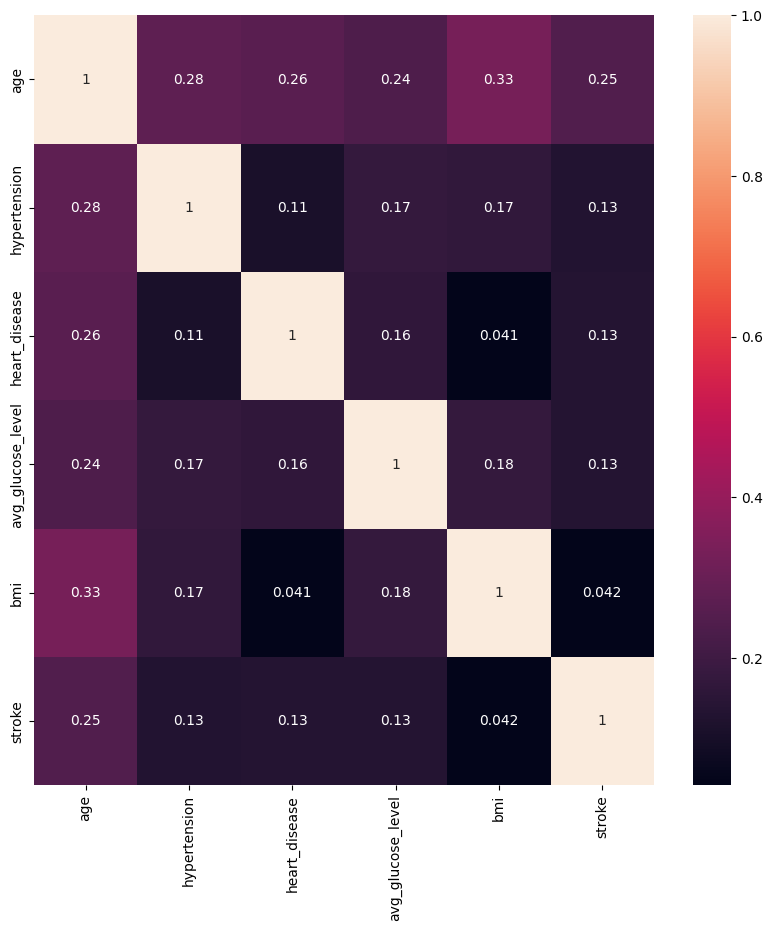

In [92]:
# Explore the relationships between variables witha correlation heatmap
corr = df.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, annot = True);

**Interpretation**
- There is a strong positive correlation between bmi and age
- There is a weak positive correlation between hypertension and heart disease
- There is a strong positive correlation between hypertension and age


####Selected Visualisations

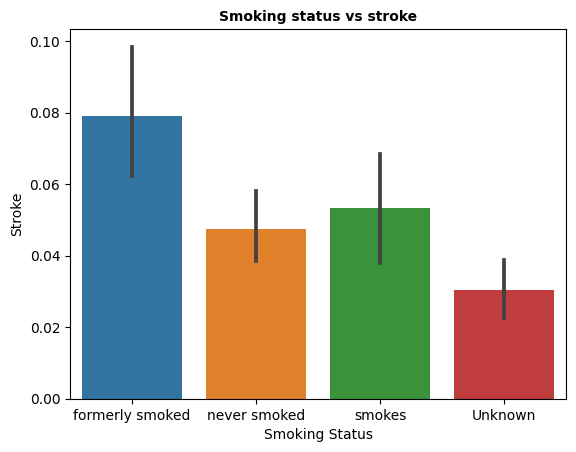

In [93]:
# Using seaborn to plot the comparison
ax = sns.barplot(data=df, x='smoking_status', y="stroke")
# Add title and labels
ax.set_ylabel('Stroke')
ax.set_xlabel("Smoking Status");
plt.title(f"Smoking status vs stroke", size=10, fontweight="black");

**Interpretation**
- A person that smoked before is more likely to have a stroke
- A person that did not smoke is less likely to have a stroke than a person that smokes

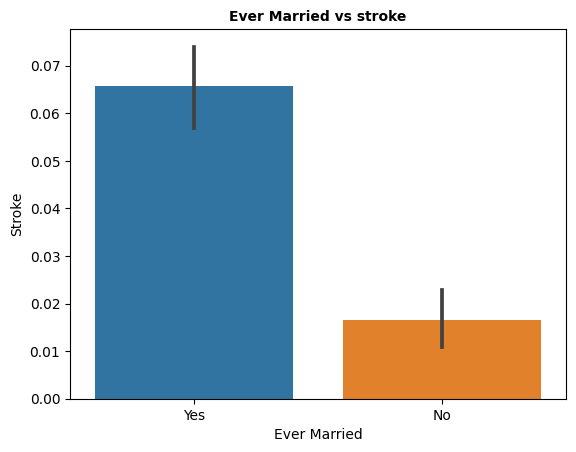

In [94]:
# Using seaborn to plot the comparison
ax = sns.barplot(data=df, x='ever_married', y="stroke")
# Add title and labels
ax.set_ylabel('Stroke')
ax.set_xlabel("Ever Married");
plt.title(f"Ever Married vs stroke", size=10, fontweight="black");

**Interpretation**
- The married people are more likely to suffer a stroke


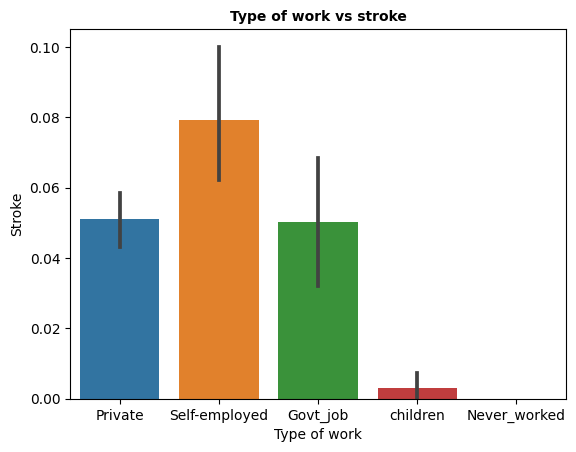

In [95]:
# Using seaborn to plot the comparison
ax = sns.barplot(data=df, x='work_type', y="stroke")
# Add title and labels
ax.set_ylabel('Stroke')
ax.set_xlabel("Type of work");
plt.title(f"Type of work vs stroke", size=10, fontweight="black");

**Interpretation**
- Self employed people are more likely to suffer a stroke

#**6. Preparing the data for modeling**

##Check the balance

In [96]:
#Check Class/Target balance
print(df['stroke'].value_counts(normalize=True))

0    0.951262
1    0.048738
Name: stroke, dtype: float64


###**Interpretation**
- The Target data is very unbalanced


##Define target and features and train-test-split

In [97]:
#Define X and Y
# The target we are trying to predict
y = df['stroke']
# The features we will use to make the prediction
X = df.drop(['stroke'], axis=1)

In [98]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
X_train.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
3587,Female,72.00,1,1,Yes,Private,Urban,198.32,31.3,formerly smoked
1470,Male,18.00,0,0,No,Private,Urban,83.02,40.4,Unknown
4432,Female,13.00,0,0,No,children,Rural,146.10,22.8,never smoked
2397,Male,1.64,0,0,No,children,Urban,115.12,21.1,Unknown
717,Female,13.00,0,0,No,children,Rural,63.26,19.5,Unknown


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_0, *['age'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_1, *['hypertension'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_2, *['heart_disease'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_3, *['avg_glucose_level'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_4, *['age'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_5, *['hypertension'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_6, *['heart_disease'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_7, *['avg_glucose_level'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(_df_8, *['gender'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(_df_9, *['ever_married'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(_df_10, *['work_type'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(_df_11, *['Residence_type'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 6 * figscale, 6 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(_df_12, *[[['age', 'hypertension'], ['hypertension', 'heart_disease'], ['heart_disease', 'avg_glucose_level'], ['avg_glucose_level', 'bmi']]], **{})
chart

import numpy as np
from google.colab import autoviz

def heatmap(df, x_colname, y_colname, figscale=1, mpl_palette_name='viridis'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  import pandas as pd
  plt.subplots(figsize=(8 * figscale, 8 * figscale))
  df_2dhist = pd.DataFrame({
      x_label: grp[y_colname].value_counts()
      for x_label, grp in df.groupby(x_colname)
  })
  sns.heatmap(df_2dhist, cmap=mpl_palette_name)
  plt.xlabel(x_colname)
  plt.ylabel(y_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = heatmap(_df_13, *['gender', 'ever_married'], **{})
chart

import numpy as np
from google.colab import autoviz

def heatmap(df, x_colname, y_colname, figscale=1, mpl_palette_name='viridis'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  import pandas as pd
  plt.subplots(figsize=(8 * figscale, 8 * figscale))
  df_2dhist = pd.DataFrame({
      x_label: grp[y_colname].value_counts()
      for x_label, grp in df.groupby(x_colname)
  })
  sns.heatmap(df_2dhist, cmap=mpl_palette_name)
  plt.xlabel(x_colname)
  plt.ylabel(y_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = heatmap(_df_14, *['ever_married', 'work_type'], **{})
chart

import numpy as np
from google.colab import autoviz

def heatmap(df, x_colname, y_colname, figscale=1, mpl_palette_name='viridis'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  import pandas as pd
  plt.subplots(figsize=(8 * figscale, 8 * figscale))
  df_2dhist = pd.DataFrame({
      x_label: grp[y_colname].value_counts()
      for x_label, grp in df.groupby(x_colname)
  })
  sns.heatmap(df_2dhist, cmap=mpl_palette_name)
  plt.xlabel(x_colname)
  plt.ylabel(y_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = heatmap(_df_15, *['work_type', 'Residence_type'], **{})
chart

import numpy as np
from google.colab import autoviz

def heatmap(df, x_colname, y_colname, figscale=1, mpl_palette_name='viridis'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  import pandas as pd
  plt.subplots(figsize=(8 * figscale, 8 * figscale))
  df_2dhist = pd.DataFrame({
      x_label: grp[y_colname].value_counts()
      for x_label, grp in df.groupby(x_colname)
  })
  sns.heatmap(df_2dhist, cmap=mpl_palette_name)
  plt.xlabel(x_colname)
  plt.ylabel(y_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = heatmap(_df_16, *['Residence_type', 'smoking_status'], **{})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(_df_17, *['age', 'gender'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(_df_18, *['age', 'ever_married'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(_df_19, *['age', 'work_type'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(_df_20, *['age', 'Residence_type'], **{'inner': 'stick'})
chart

##Check balance on train and test data

In [99]:
# Check how many samples of each class are present for train
y_train.value_counts(normalize=True)

0    0.951188
1    0.048812
Name: stroke, dtype: float64

In [100]:
y_test.value_counts(normalize=True)

0    0.951487
1    0.048513
Name: stroke, dtype: float64

##Create column transfer

In [101]:
#Numeric column names list
num_cols = X_train.select_dtypes("number").columns
print("Numeric Columns:", num_cols)

Numeric Columns: Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'], dtype='object')


##Scale and Create the numeric pipeline

In [102]:
#Use Mean strategy for numeric as we are looking for average values to ensure balance of the data
impute_mean = SimpleImputer(strategy='mean')
scaler = StandardScaler()

# Make a numeric preprocessing pipeline
num_pipe = make_pipeline(impute_mean, scaler)
num_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

##Create Ordinal Pipeline

- smoking status

These are ordinal data dtypes, therefore the use of ordinal encoding is applicable

In [103]:
#Ordinal preprocessing and Pipeline

#Ordered category list
ss_list = ["never smoked", "formerly smoked", "smokes"]
#Column names
ord_cols = ["smoking_status"]
#Impute strategy for null values
impute_null_ord = SimpleImputer(strategy='most_frequent')

#Transform
ord_encoder = OrdinalEncoder(categories=[ss_list], handle_unknown='use_encoded_value',unknown_value = -1)
scaler_ord = StandardScaler()
#instantiate the pipeline
ord_pipeline = make_pipeline(impute_null_ord, ord_encoder, scaler_ord)
ord_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['never smoked', 'formerly smoked',
                                             'smokes']],
                                handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('standardscaler', StandardScaler())])

##Create the tuple for Ordinal

In [104]:
#Create the tuple for Ordinal
ord_tuple = ('ordinal', ord_pipeline, ord_cols)
ord_tuple

('ordinal',
 Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                 ('ordinalencoder',
                  OrdinalEncoder(categories=[['never smoked', 'formerly smoked',
                                              'smokes']],
                                 handle_unknown='use_encoded_value',
                                 unknown_value=-1)),
                 ('standardscaler', StandardScaler())]),
 ['smoking_status'])

##Create the tuple for numeric

In [105]:
#Create the tuple for numeric
num_tuple = ('numeric', num_pipe, num_cols)
num_tuple

('numeric',
 Pipeline(steps=[('simpleimputer', SimpleImputer()),
                 ('standardscaler', StandardScaler())]),
 Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'], dtype='object'))

##Select the categorical columns and create the pipeline

In [106]:
#Categorical column names list
cat_cols = X_train.select_dtypes("object").columns
print("Cat Columns:", cat_cols)
impute_na = SimpleImputer(strategy='constant', fill_value = "Unknown")
#One Hot Encode as it is Categorical data
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Make pipeline with imputer and encoder
ohe_pipe = make_pipeline(impute_na, ohe_encoder)
ohe_pipe

Cat Columns: Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object')


Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='Unknown', strategy='constant')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

##Create the tuple for categorical

In [107]:
#Create the tuple for categorical
ohe_tuple = ('categorical', ohe_pipe, cat_cols)
ohe_tuple

('categorical',
 Pipeline(steps=[('simpleimputer',
                  SimpleImputer(fill_value='Unknown', strategy='constant')),
                 ('onehotencoder',
                  OneHotEncoder(handle_unknown='ignore', sparse_output=False))]),
 Index(['gender', 'ever_married', 'work_type', 'Residence_type',
        'smoking_status'],
       dtype='object'))

In [108]:
#Column transformer/preprocessor
col_transformer = ColumnTransformer([num_tuple, ord_tuple, ohe_tuple], remainder="passthrough", verbose_feature_names_out=False)
col_transformer



ColumnTransformer(remainder='passthrough',
                  transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'], dtype='object')),
                                ('ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  Ordi...
                                                  StandardScaler())]),
                                 ['smoking_status']),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='Unknown',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object'))],
                  verbose_feature_names_out=False)

##Fit column transformer onto the data

In [109]:
#fit to training data only or you would create data leakage
col_transformer.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'], dtype='object')),
                                ('ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  Ordi...
                                                  StandardScaler())]),
                                 ['smoking_status']),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='Unknown',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object'))],
                  verbose_feature_names_out=False)

In [110]:
# Transform the training data
X_train_processed = col_transformer.transform(X_train)
# Transform the testing data
X_test_processed = col_transformer.transform(X_test)
# View the processed training data
X_train_processed.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,gender_Female,gender_Male,ever_married_No,ever_married_Yes,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
3587,1.267791,3.124298,4.090979,2.086958,0.318986,0.808924,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1470,-1.116387,-0.320072,-0.244440,-0.509269,1.502170,-1.145041,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4432,-1.337144,-0.320072,-0.244440,0.911112,-0.786186,-0.168058,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2397,-1.838704,-0.320072,-0.244440,0.213531,-1.007220,-1.145041,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
717,-1.337144,-0.320072,-0.244440,-0.954208,-1.215253,-1.145041,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0


In [111]:
# Check # of null values in X_train
X_train_processed.isna().sum()

age                               0
hypertension                      0
heart_disease                     0
avg_glucose_level                 0
bmi                               0
smoking_status                    0
gender_Female                     0
gender_Male                       0
ever_married_No                   0
ever_married_Yes                  0
work_type_Govt_job                0
work_type_Never_worked            0
work_type_Private                 0
work_type_Self-employed           0
work_type_children                0
Residence_type_Rural              0
Residence_type_Urban              0
smoking_status_Unknown            0
smoking_status_formerly smoked    0
smoking_status_never smoked       0
smoking_status_smokes             0
dtype: int64

In [112]:
# Check X_train dtypes
X_train_processed.dtypes

age                               float64
hypertension                      float64
heart_disease                     float64
avg_glucose_level                 float64
bmi                               float64
smoking_status                    float64
gender_Female                     float64
gender_Male                       float64
ever_married_No                   float64
ever_married_Yes                  float64
work_type_Govt_job                float64
work_type_Never_worked            float64
work_type_Private                 float64
work_type_Self-employed           float64
work_type_children                float64
Residence_type_Rural              float64
Residence_type_Urban              float64
smoking_status_Unknown            float64
smoking_status_formerly smoked    float64
smoking_status_never smoked       float64
smoking_status_smokes             float64
dtype: object

##Check if it has been scaled

In [113]:
#Confirming Numeric
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3831 entries, 3587 to 5053
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             3831 non-null   object 
 1   age                3831 non-null   float64
 2   hypertension       3831 non-null   int64  
 3   heart_disease      3831 non-null   int64  
 4   ever_married       3831 non-null   object 
 5   work_type          3831 non-null   object 
 6   Residence_type     3831 non-null   object 
 7   avg_glucose_level  3831 non-null   float64
 8   bmi                3681 non-null   float64
 9   smoking_status     3831 non-null   object 
dtypes: float64(3), int64(2), object(5)
memory usage: 329.2+ KB


In [114]:
#Confirming Numeric
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1278 entries, 3922 to 68
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             1278 non-null   object 
 1   age                1278 non-null   float64
 2   hypertension       1278 non-null   int64  
 3   heart_disease      1278 non-null   int64  
 4   ever_married       1278 non-null   object 
 5   work_type          1278 non-null   object 
 6   Residence_type     1278 non-null   object 
 7   avg_glucose_level  1278 non-null   float64
 8   bmi                1227 non-null   float64
 9   smoking_status     1278 non-null   object 
dtypes: float64(3), int64(2), object(5)
memory usage: 109.8+ KB


#**6. Build the models**

In [115]:
labels=['Stroke','No Stroke']

##KNN Model

In [116]:
# Create an instance of the model
knn = KNeighborsClassifier()
# Create a model pipeline
knn_pipe = make_pipeline(col_transformer, knn)
# Fit the model
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'], dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='mo...
                                                 ('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('kneighborsclassifier', KNeighborsClassifier())])

### KNN model evaluation

Train Report
              precision    recall  f1-score   support

      Stroke       0.95      1.00      0.98      3644
   No Stroke       0.56      0.05      0.10       187

    accuracy                           0.95      3831
   macro avg       0.75      0.53      0.54      3831
weighted avg       0.93      0.95      0.93      3831

Test Report
              precision    recall  f1-score   support

      Stroke       0.95      1.00      0.97      1216
   No Stroke       0.14      0.02      0.03        62

    accuracy                           0.95      1278
   macro avg       0.55      0.51      0.50      1278
weighted avg       0.91      0.95      0.93      1278

Training ROC AUC: 0.94
Test ROC AUC: 0.60



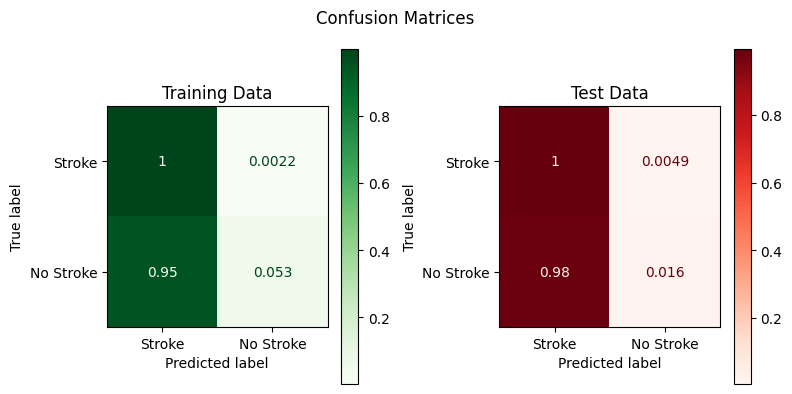

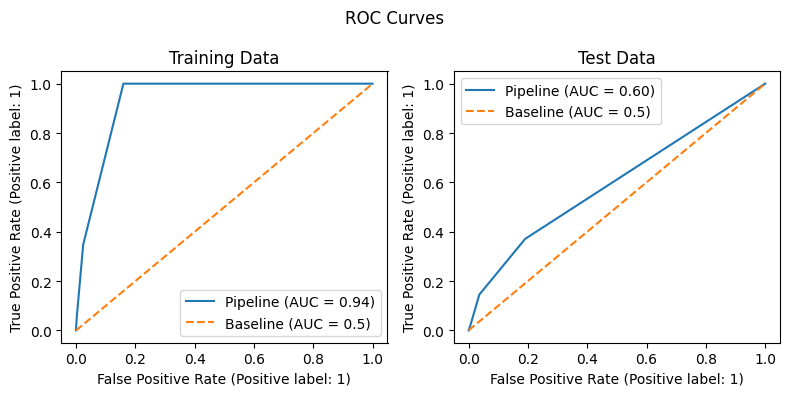

In [117]:
#Use function to evaluate the default model
evaluate_model(knn_pipe, X_train, y_train, X_test, y_test, labels)

**Interpretation**
- Accuracy is 95% and the aim is to bring the accuracy up.
- The FN is 98%, which is high considering that you want to identify who will most likely have a stroke
- The FN should be reduced to ensure correct you identify who is more likely to have a stroke
-Due to the low AUC value, this is possibly a bad model

###Tune the model

In [118]:
# Display the hyperparameters.
knn_pipe.get_params()
# Create a dictionary of parameters
params = {'kneighborsclassifier__n_neighbors': range(1,15),
          'kneighborsclassifier__weights': ['distance','uniform']}

# Tune hyperparameters with GridSearchCV
knn_gs = GridSearchCV(knn_pipe, params)
knn_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('numeric',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'], dtype='object')),
                                                                        ('ordinal',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          Sim...
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object'))],
                                                          verbose_feature_names_out=False)),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__n_neighbors': range(1, 15),
                         'kneighborsclassifier__weights': ['distance',
                                                           'uniform']})

In [119]:
#Get the best aparameters
knn_gs.best_params_

{'kneighborsclassifier__n_neighbors': 8,
 'kneighborsclassifier__weights': 'uniform'}

In [120]:
#Get the best score and estimator
knn_gs.best_score_
best_knn = knn_gs.best_estimator_

### Evaluate Tuned model

Train Report
              precision    recall  f1-score   support

      Stroke       0.95      1.00      0.98      3644
   No Stroke       0.60      0.02      0.03       187

    accuracy                           0.95      3831
   macro avg       0.78      0.51      0.50      3831
weighted avg       0.93      0.95      0.93      3831

Test Report
              precision    recall  f1-score   support

      Stroke       0.95      1.00      0.97      1216
   No Stroke       0.00      0.00      0.00        62

    accuracy                           0.95      1278
   macro avg       0.48      0.50      0.49      1278
weighted avg       0.91      0.95      0.93      1278

Training ROC AUC: 0.92
Test ROC AUC: 0.64



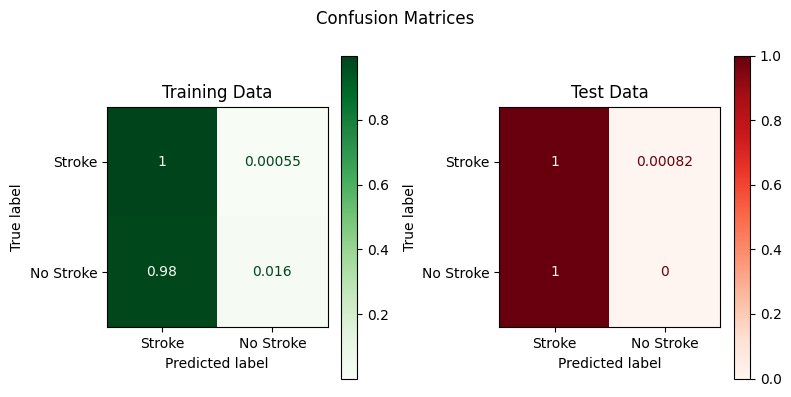

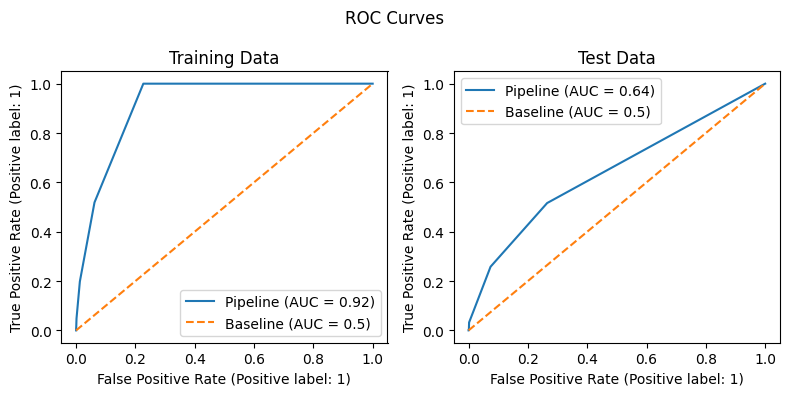

In [121]:
#Evaluate the tuned model
evaluate_model(best_knn, X_train, y_train, X_test, y_test, labels)

**Interpretation**
- Accuracy has increased 100%.
- The FP has reduced with an improved recall
- Area under curve inceased to 64% but decreases faster as the FP increases, which the model needs further tuning

##Random Forest model

In [122]:
#Define model, make pipeline and fit model
rfc_pipe = make_pipeline(col_transformer, RandomForestClassifier(random_state = 42))
rfc_pipe.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'], dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='mo...
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

###Random Forest model evaluation

Train Report
              precision    recall  f1-score   support

      Stroke       1.00      1.00      1.00      3644
   No Stroke       1.00      1.00      1.00       187

    accuracy                           1.00      3831
   macro avg       1.00      1.00      1.00      3831
weighted avg       1.00      1.00      1.00      3831

Test Report
              precision    recall  f1-score   support

      Stroke       0.95      1.00      0.97      1216
   No Stroke       0.00      0.00      0.00        62

    accuracy                           0.95      1278
   macro avg       0.48      0.50      0.49      1278
weighted avg       0.91      0.95      0.93      1278

Training ROC AUC: 1.00
Test ROC AUC: 0.79



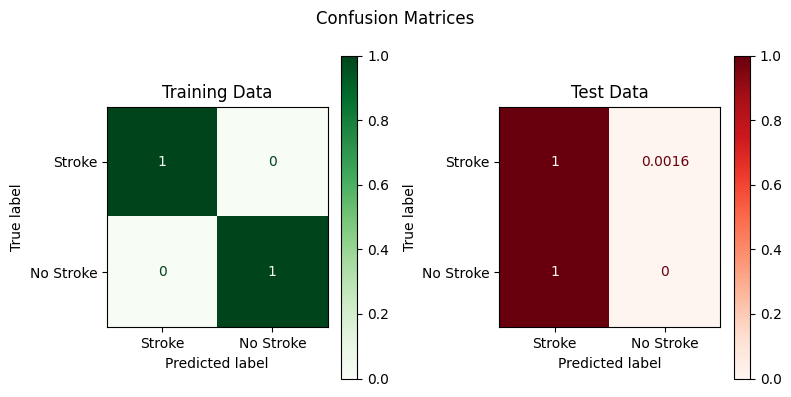

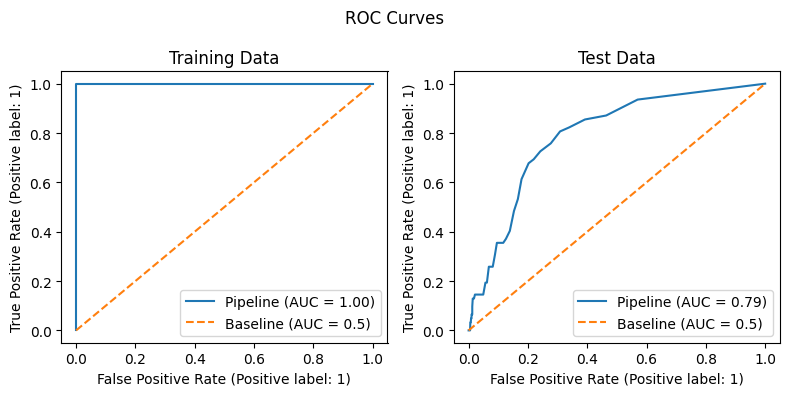

In [123]:
## Evaluate model's performance
evaluate_model(rfc_pipe, X_train, y_train, X_test, y_test, labels)

**Interpretation**
- Accuracy is 95%
- AUC is 79%, which is better than the KNN model



###Tune the model

In [124]:
# Display the hyperparameters.
rfc_pipe.get_params()

# Create a dictionary of parameters
params = {'randomforestclassifier__max_depth':[None,10,15,20],
          'randomforestclassifier__oob_score':[True,False]
          }

In [125]:
# Tune hyperparameters with GridSearchCV
rfc_gs = GridSearchCV(rfc_pipe, params)
rfc_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('numeric',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'], dtype='object')),
                                                                        ('ordinal',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          Sim...
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object'))],
                                                          verbose_feature_names_out=False)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'randomforestclassifier__max_depth': [None, 10, 15,
                                                               20],
                         'randomforestclassifier__oob_score': [True, False]})

In [126]:
#Get the best aparameters
rfc_gs.best_params_
#Get the best score and estimator
rfc_gs.best_score_
best_rfc_tree = rfc_gs.best_estimator_

### Evaluate Tuned model

Train Report
              precision    recall  f1-score   support

      Stroke       0.97      1.00      0.98      3644
   No Stroke       1.00      0.32      0.49       187

    accuracy                           0.97      3831
   macro avg       0.98      0.66      0.73      3831
weighted avg       0.97      0.97      0.96      3831

Test Report
              precision    recall  f1-score   support

      Stroke       0.95      1.00      0.98      1216
   No Stroke       0.67      0.03      0.06        62

    accuracy                           0.95      1278
   macro avg       0.81      0.52      0.52      1278
weighted avg       0.94      0.95      0.93      1278

Training ROC AUC: 1.00
Test ROC AUC: 0.82



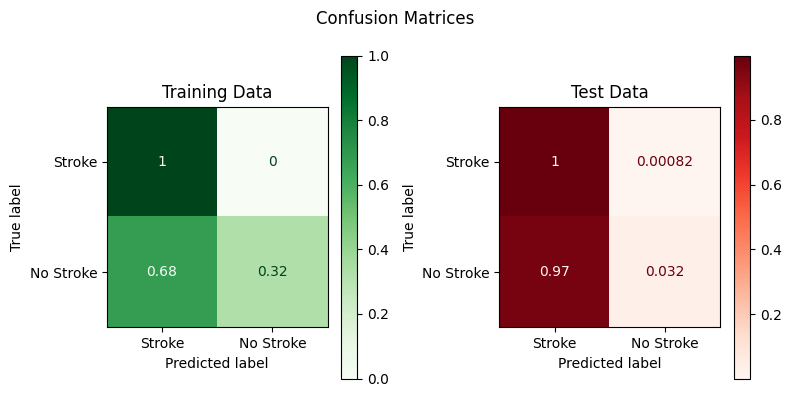

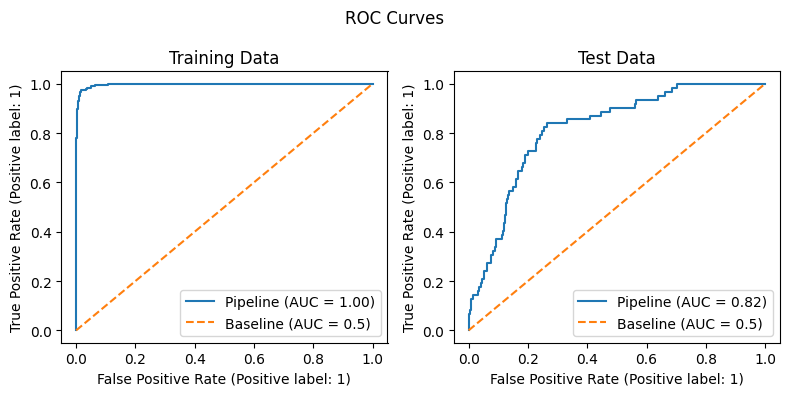

In [127]:
#Evaluate the tuned model
evaluate_model(best_rfc_tree, X_train, y_train, X_test, y_test, labels)

**Interpretation**
- Accuracy is 95% and the aim is to bring the accuracy up.
- F1-score is 98%, showing that the tunes models quality is better
- AUC is 82% indicating a very good fit

##PCA on the Random Forest model

In [144]:
rfc = RandomForestClassifier(random_state = 42)
# Instantiate & fit data using PCA with 95% variance
pca = PCA(n_components=0.75)
pca_processing = make_pipeline(col_transformer, pca)

#Understand PCA data
print('Shape before PCA:', X_train.shape)
print('Shape after PCA:', pca_processing.fit_transform(X_train).shape)
print('Column count reduced by: ', X_train.shape[1] - pca_processing.fit_transform(X_train).shape[1])

Shape before PCA: (3831, 10)
Shape after PCA: (3831, 6)
Column count reduced by:  4


In [145]:
#Make pipeline with PCA
pca_rfc_pipe = make_pipeline(col_transformer, pca, rfc)
# Fit the model
pca_rfc_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'], dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='mo...
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('pca', PCA(n_components=0.75)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

Train Report
              precision    recall  f1-score   support

      Stroke       1.00      1.00      1.00      3644
   No Stroke       1.00      1.00      1.00       187

    accuracy                           1.00      3831
   macro avg       1.00      1.00      1.00      3831
weighted avg       1.00      1.00      1.00      3831

Test Report
              precision    recall  f1-score   support

      Stroke       0.95      0.99      0.97      1216
   No Stroke       0.12      0.02      0.03        62

    accuracy                           0.95      1278
   macro avg       0.54      0.51      0.50      1278
weighted avg       0.91      0.95      0.93      1278

Training ROC AUC: 1.00
Test ROC AUC: 0.75



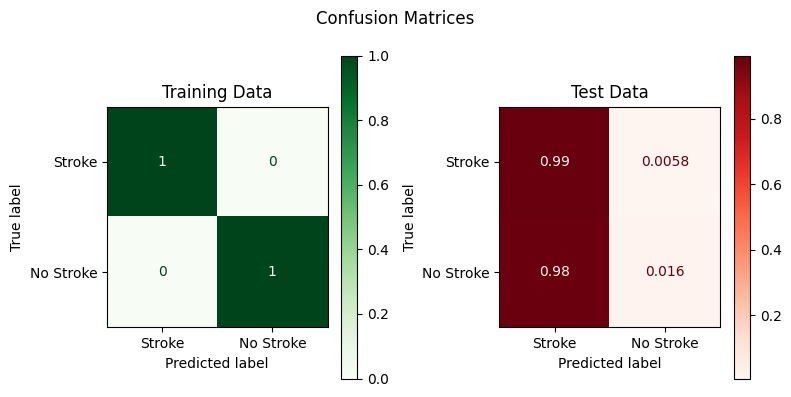

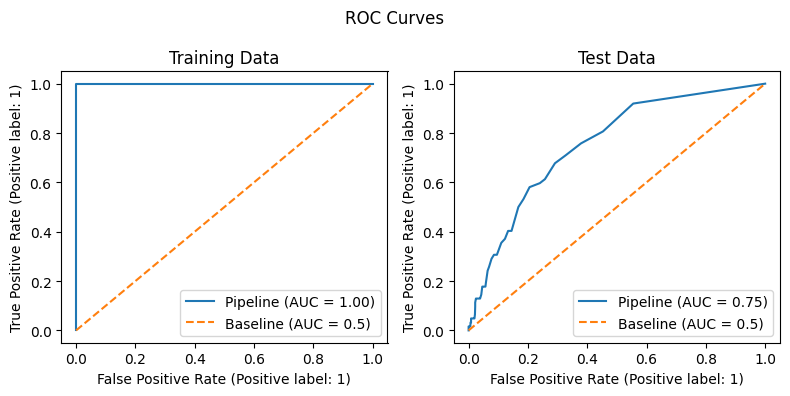

CPU times: user 2.1 s, sys: 284 ms, total: 2.38 s
Wall time: 2.4 s


In [142]:
%%time
## Evaluate model's performance
evaluate_model(pca_rfc_pipe, X_train, y_train, X_test, y_test, labels)

In [143]:
%%time
preds_pca = pca_rfc_pipe.predict(X_test)

CPU times: user 41.7 ms, sys: 768 µs, total: 42.5 ms
Wall time: 43.4 ms


**Interpretation**
- PCA has sped up the model prediction
- AUC has been reduced to 75% with the reduction in columns by 4
- The Tuned Random Forest model is oreffered due to accuracy and AUC at 82%